# Importando bibliotecas

In [1]:
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

# Carregando o _dataset_

In [2]:
dataset = pd.read_csv("arruela_.csv")
dataset.head()

,Hora,Tamanho,Referencia,NumAmostra,Area,Delta,Output1,Output2
0,13:00:06,53,25,69,81,68,1,0
1,13:00:07,53,26,89,87,56,1,0
2,13:00:08,53,27,68,69,55,1,0
3,13:00:09,53,28,36,50,80,1,0
4,13:00:10,53,29,71,72,50,1,0


## Obtendo informações sobre o _dataset_

In [3]:
dataset.describe()

,Tamanho,Referencia,NumAmostra,Area,Delta,Output1,Output2
count,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000
mean,53.126437,58.310345,59.777778,63.697318,54.747126,0.375479,0.624521
std,1.174779,9.199888,17.293075,30.629366,35.548413,0.485177,0.485177
min,53.000000,25.000000,3.000000,6.000000,17.000000,0.000000,0.000000
25%,53.000000,54.000000,50.000000,46.000000,38.000000,0.000000,0.000000
50%,53.000000,64.000000,59.000000,56.000000,44.000000,0.000000,1.000000
75%,53.000000,64.000000,69.000000,68.000000,54.000000,1.000000,1.000000
max,64.000000,64.000000,120.000000,201.000000,251.000000,1.000000,1.000000


## Retirando colunas desnecessárias

In [4]:
dataset.drop(["Hora", "Tamanho", "Referencia"], axis=1, inplace=True)
dataset.head()

,NumAmostra,Area,Delta,Output1,Output2
0,69,81,68,1,0
1,89,87,56,1,0
2,68,69,55,1,0
3,36,50,80,1,0
4,71,72,50,1,0


# Separando o _dataset_ em `X` e `y`

In [5]:
X_cols = ["NumAmostra", "Delta", "Area"]
y_cols = ["Output1", "Output2"]

X = dataset[X_cols]
y = dataset[y_cols]

# Normalização do _dataset_

- Como as variáveis de saída já são discretas (0 ou 1), não é necessário normalizá-las

In [6]:
sscaler = StandardScaler()
X = sscaler.fit_transform(X)
X = pd.DataFrame(X, columns=X_cols)
X.head()

,NumAmostra,Delta,Area
0,0.534314,0.373528,0.565990
1,1.693069,0.035312,0.762257
2,0.476377,0.007127,0.173457
3,-1.377630,0.711745,-0.448055
4,0.650190,-0.133796,0.271590


# Segmentando em _dataset_ de treino e teste

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=64)

# Construindo a rede neural

In [8]:
# função de ativação

sigmoid = lambda x: 1/(1+np.exp(-x))

# tamanho do dataset de treinamento

n_records, n_features = X_train.shape
_, n_outputs = y_train.shape

# camadas e neurônios

layers = [n_features, 10, n_outputs]

# taxa de aprendizado

lr = 0.1

# Inicializando os pesos da rede

In [9]:
weights = []
for i, lay in enumerate(layers[:-1]):
    w = np.random.normal(0, scale=0.1, size=(lay, layers[i+1]))
    weights.append(w.copy())

# _Backpropagation_

In [10]:
last_loss = None

error_evolution = []
error_index = []

epochs = 8000

for ep in range(epochs):
    # inicializa deltas
    
    deltas = []
    
    for w in weights:
        zeros = np.zeros(w.shape)
        deltas.append(zeros.copy())
        
    # itera sobre o dataset de treinamento
    
    for xi, yi in zip(X_train.to_numpy(), y_train.to_numpy()):
        
        # passagem para frente
        
        outputs = []
        
        for i, _ in enumerate(layers[1:]): # descarta camada de entrada
            if i == 0: # usar dados de entrada
                dot = np.dot(xi, weights[i])
            else:
                dot = np.dot(outputs[-1], weights[i])

            outputs.append(sigmoid(dot))
        
        # passagem para trás
        
        error_terms = deque()
        
        for i in range(len(layers)-1, 0, -1):
            if i == len(layers)-1: # usar dados de saída
                error = yi - outputs[-1]
            else:
                error = np.dot(weights[i], error_terms[0])
                
            error_term = error * outputs[i-1] * (1-outputs[i-1])
            error_terms.appendleft(error_term.copy())
            
            if i == 1:
                deltas[i-1] += error_term * xi.reshape(-1, 1)
            else:
                deltas[i-1] += error_term * outputs[i-2].reshape(-1, 1)
                
    # atualiza pesos
    
    for i, w in enumerate(weights):
        weights[i] += (lr * deltas[i]) / n_records
        
    # calcula e coleta erro
    
    if ep % (epochs / 20) == 0:
        loss = np.mean((outputs[-1] - yi) ** 2)

        error_evolution.append(loss)
        error_index.append(ep)

        print(f"[{ep}] Erro no treinamento: {loss}", end="")
        if last_loss and loss > last_loss: print(" (ERRO AUMENTANDO)", end="")
        print()
        last_loss = loss
        
# coleta erro final

if (error_index[-1] != ep):
    loss = np.mean((outputs[-1] - yi) ** 2)
    
    error_evolution.append(loss)
    error_index.append(ep)
    
    print(f"[{ep}] Erro no treinamento: {loss}")
        
print("-"*40)

[0] Erro no treinamento: 0.2231067848395311
[400] Erro no treinamento: 0.12216649511072789
[800] Erro no treinamento: 0.11044226482055225
[1200] Erro no treinamento: 0.09617972452136295
[1600] Erro no treinamento: 0.07845279456567263
[2000] Erro no treinamento: 0.05950111699038278
[2400] Erro no treinamento: 0.04298967757343658
[2800] Erro no treinamento: 0.030593649647125784
[3200] Erro no treinamento: 0.02190896112167328
[3600] Erro no treinamento: 0.015898555499024414
[4000] Erro no treinamento: 0.011664666678954844
[4400] Erro no treinamento: 0.008600533826495955
[4800] Erro no treinamento: 0.006333591445777986
[5200] Erro no treinamento: 0.004640417870376806
[5600] Erro no treinamento: 0.0033798800813985754
[6000] Erro no treinamento: 0.0024518161467579434
[6400] Erro no treinamento: 0.0017775515196670956
[6800] Erro no treinamento: 0.0012932139967475524
[7200] Erro no treinamento: 0.0009478080778209457
[7600] Erro no treinamento: 0.0007020473376750983
[7999] Erro no treinamento: 

# Plotando a evolução do erro

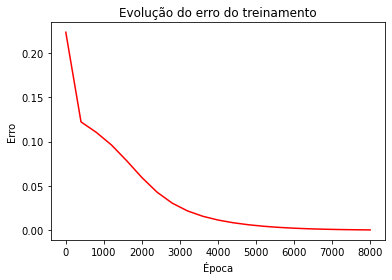

In [11]:
plt.plot(error_index, error_evolution, color="red")
plt.xlabel("Época")
plt.ylabel("Erro")
plt.title("Evolução do erro do treinamento")
plt.show()

# Validando o modelo

In [12]:
n_records, n_features = X_test.shape

positives = 0

for xi, yi in zip(X_test.values, y_test.values):
    # passagem para frente
    
    outputs = []
        
    for i, _ in enumerate(layers[1:]): # descarta camada de entrada
        if i == 0: # usar dados de entrada
            dot = np.dot(xi, weights[i])
        else:
            dot = np.dot(outputs[-1], weights[i])

        outputs.append(sigmoid(dot))
        
    output = outputs[-1]
    
    # compara predição com resultado esperado
    
    if (output[0] > output[1] and yi[0] > yi[1]
        or output[0] < output[1] and yi[0] < yi[1]):
        positives += 1
    
# calcula acurácia do modelo

accuracy = positives / n_records
print("Acurácia do modelo: {:.3f}".format(accuracy))

Acurácia do modelo: 0.920
